In [50]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [41]:
df = pd.read_csv('C:/Users/hhhwa/Desktop/process_data/DOM_hourly.csv',index_col='Datetime', parse_dates=['Datetime'])

In [42]:
df

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0
...,...
2018-01-01 20:00:00,18418.0
2018-01-01 21:00:00,18567.0
2018-01-01 22:00:00,18307.0


In [43]:
df['DOM_MW'].describe()

count    116189.000000
mean      10949.203625
std        2413.946569
min        1253.000000
25%        9322.000000
50%       10501.000000
75%       12378.000000
max       21651.000000
Name: DOM_MW, dtype: float64

In [44]:
#checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

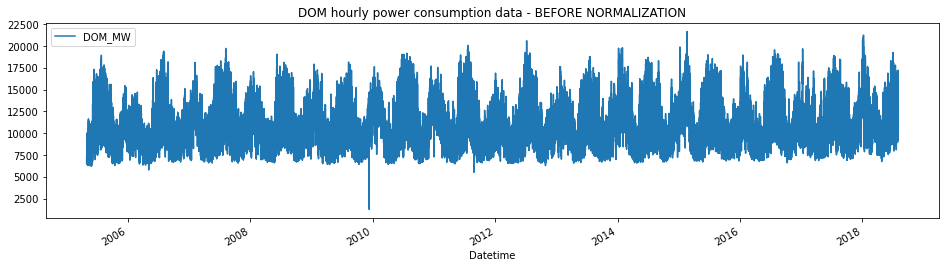

In [7]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

Normalize data

In [8]:
def norm_test(x):
    return (x-df['DOM_MW'].mean())/df['DOM_MW'].std()


In [9]:
df['DOM_MW']=norm_test(df['DOM_MW'])

In [10]:
df

,DOM_MW
Datetime,
2005-12-31 01:00:00,-0.646329
2005-12-31 02:00:00,-0.778478
2005-12-31 03:00:00,-0.807062
2005-12-31 04:00:00,-0.790077
2005-12-31 05:00:00,-0.752794
...,...
2018-01-01 20:00:00,3.094019
2018-01-01 21:00:00,3.155744
2018-01-01 22:00:00,3.048036


In [45]:
#def normalize_data(df):
#    scaler = sklearn.preprocessing.MinMaxScaler()
#    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
#    return df

#df = normalize_data(df)
#df.shape

(116189, 1)

Visualize data after normalization

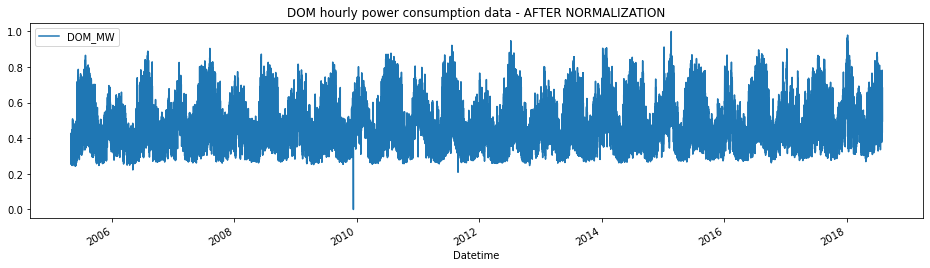

In [46]:
#df.plot(figsize=(16,4),legend=True)

#plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

#plt.show()

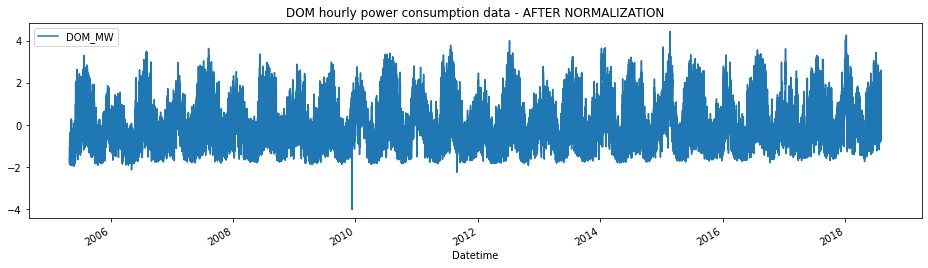

In [14]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

Prepare data for training the RNN models

In [15]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]

    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [16]:
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


In [17]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [22]:
rnn_model.compile(optimizer="adam",loss="MSE")
hist_1 = rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000, validation_split=0.2, shuffle=False)

Train on 88000 samples, validate on 22000 samples
Epoch 1/10
88000/88000 [==============================] - 8s 86us/step - loss: 0.0395 - val_loss: 0.0285
Epoch 2/10
88000/88000 [==============================] - 8s 88us/step - loss: 0.0378 - val_loss: 0.0272
Epoch 3/10
88000/88000 [==============================] - 7s 80us/step - loss: 0.0366 - val_loss: 0.0268
Epoch 4/10
88000/88000 [==============================] - 7s 82us/step - loss: 0.0363 - val_loss: 0.0276
Epoch 5/10
88000/88000 [==============================] - 7s 81us/step - loss: 0.0359 - val_loss: 0.0271
Epoch 6/10
88000/88000 [==============================] - 7s 81us/step - loss: 0.0348 - val_loss: 0.0267
Epoch 7/10
88000/88000 [==============================] - 7s 82us/step - loss: 0.0342 - val_loss: 0.0262
Epoch 8/10
88000/88000 [==============================] - 7s 82us/step - loss: 0.0352 - val_loss: 0.0287
Epoch 9/10
88000/88000 [==============================] - 7s 84us/step - loss: 0.0337 - val_loss: 0.0262
Epoch

Performance Evaluation

In [23]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9633696978822749


In [52]:
rnn_train_pred = rnn_model.predict(X_train)
rnn_test_pred = rnn_model.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, rnn_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, rnn_test_pred)))

Train rmse: 0.1538461189473466
Test rmse: 0.1990723341363923


Compare the actual values vs predicted values by plotting a graph

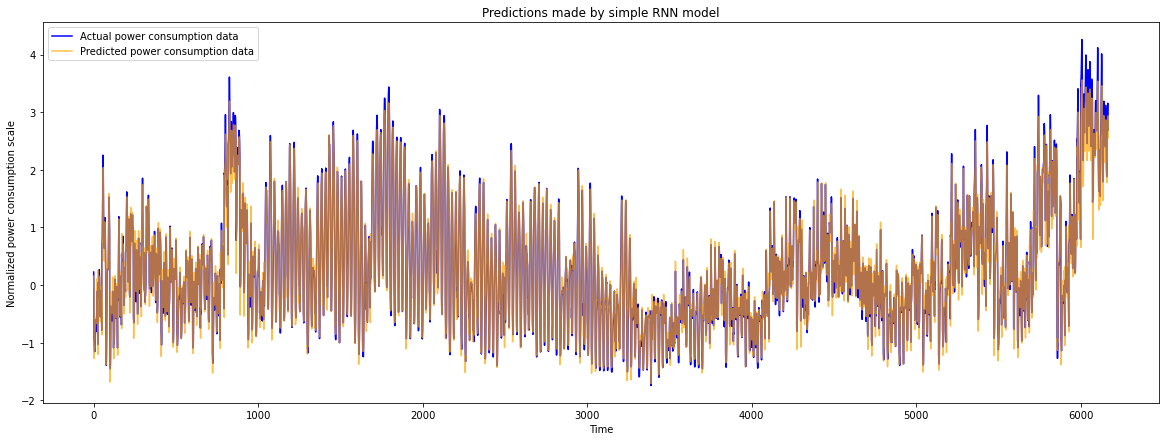

In [24]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(20,7))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

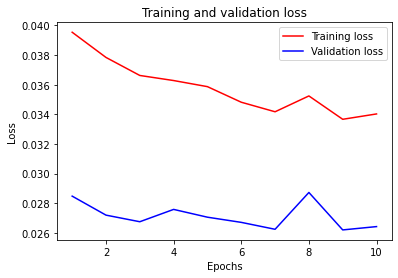

In [25]:
import matplotlib.pyplot as plt

loss = hist_1.history['loss']
val_loss = hist_1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

LSTM model

In [26]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [27]:
lstm_model.compile(optimizer="adam",loss="MSE")
hist_2 = lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000, validation_split=0.2, shuffle=False)

Train on 88000 samples, validate on 22000 samples
Epoch 1/10
88000/88000 [==============================] - 22s 253us/step - loss: 0.6870 - val_loss: 0.3796
Epoch 2/10
88000/88000 [==============================] - 22s 250us/step - loss: 0.2424 - val_loss: 0.1610
Epoch 3/10
88000/88000 [==============================] - 25s 280us/step - loss: 0.1377 - val_loss: 0.0713
Epoch 4/10
88000/88000 [==============================] - 23s 258us/step - loss: 0.0831 - val_loss: 0.0454
Epoch 5/10
88000/88000 [==============================] - 24s 268us/step - loss: 0.0630 - val_loss: 0.0369
Epoch 6/10
88000/88000 [==============================] - 24s 276us/step - loss: 0.0533 - val_loss: 0.0328
Epoch 7/10
88000/88000 [==============================] - 25s 289us/step - loss: 0.0469 - val_loss: 0.0307
Epoch 8/10
88000/88000 [==============================] - 24s 270us/step - loss: 0.0460 - val_loss: 0.0317
Epoch 9/10
88000/88000 [==============================] - 23s 262us/step - loss: 0.0414 - val_

In [28]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9610898917979545


In [53]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_test_pred = lstm_model.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, lstm_test_pred)))

Train rmse: 0.16238589137648834
Test rmse: 0.20517378842606346


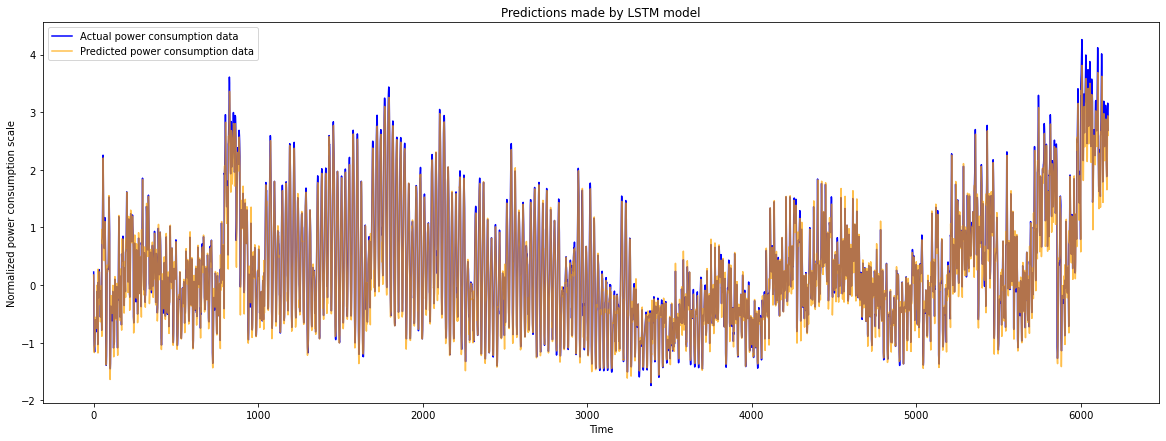

In [29]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

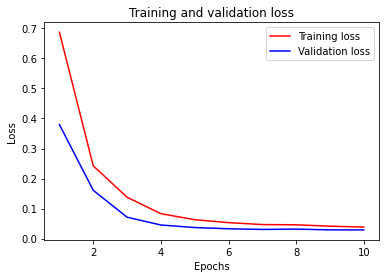

In [30]:
import matplotlib.pyplot as plt

loss = hist_2.history['loss']
val_loss = hist_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

CNN model

In [31]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

In [32]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=256, kernel_size=5, activation='relu', padding = 'same',input_shape=(X_train.shape[1],1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=128, kernel_size=4, activation='relu', padding = 'same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20, 256)           1536      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 128)           131200    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 64)             24640     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)             

In [33]:
model_cnn.compile(optimizer="adam",loss="MSE")
hist_3 = model_cnn.fit(X_train, y_train, epochs=10, batch_size=1000, validation_split=0.2, shuffle=False)

Train on 88000 samples, validate on 22000 samples
Epoch 1/10
88000/88000 [==============================] - 20s 228us/step - loss: 0.2078 - val_loss: 0.0636
Epoch 2/10
88000/88000 [==============================] - 20s 231us/step - loss: 0.0472 - val_loss: 0.0556
Epoch 3/10
88000/88000 [==============================] - 20s 225us/step - loss: 0.0361 - val_loss: 0.0277
Epoch 4/10
88000/88000 [==============================] - 20s 231us/step - loss: 0.0287 - val_loss: 0.0267
Epoch 5/10
88000/88000 [==============================] - 20s 232us/step - loss: 0.0211 - val_loss: 0.0224
Epoch 6/10
88000/88000 [==============================] - 19s 221us/step - loss: 0.0199 - val_loss: 0.0213
Epoch 7/10
88000/88000 [==============================] - 21s 236us/step - loss: 0.0257 - val_loss: 0.0253
Epoch 8/10
88000/88000 [==============================] - 22s 245us/step - loss: 0.0197 - val_loss: 0.0204
Epoch 9/10
88000/88000 [==============================] - 21s 236us/step - loss: 0.0207 - val_

In [34]:
cnn_predictions = model_cnn.predict(X_test)

cnn_score = r2_score(y_test, cnn_predictions)
print("R^2 Score of CNN model = ",cnn_score)

R^2 Score of CNN model =  0.973286431078222


In [55]:
cnn_train_pred = model_cnn.predict(X_train)
cnn_test_pred = model_cnn.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, cnn_test_pred)))

Train rmse: 0.1312085653768668
Test rmse: 0.1700030116240499


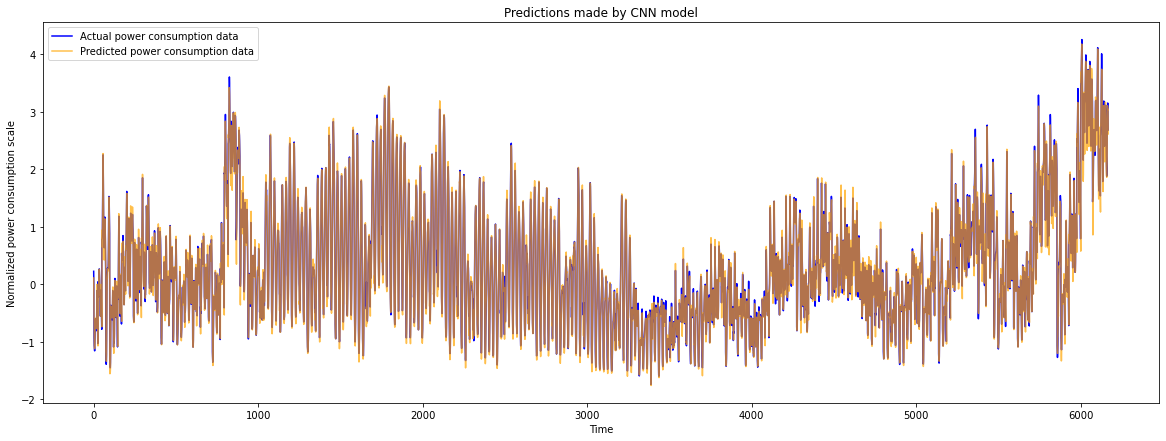

In [35]:
plot_predictions(y_test, cnn_predictions, "Predictions made by CNN model")

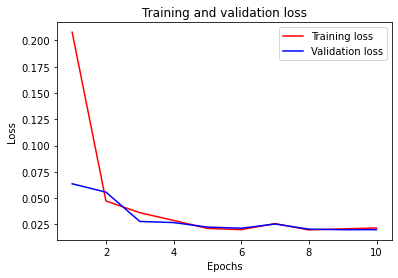

In [36]:
import matplotlib.pyplot as plt

loss = hist_3.history['loss']
val_loss = hist_3.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

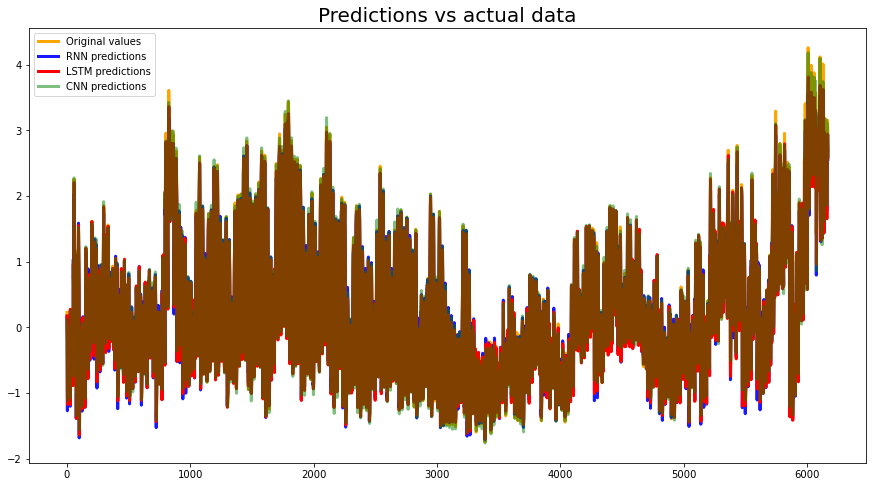

In [40]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(rnn_predictions, alpha=0.9, c="blue", linewidth=3, label="RNN predictions")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(cnn_predictions, alpha=0.5, c="green", linewidth=3, label="CNN predictions")

plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()